# MULTIVARIATE ANALYSIS CODE

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import scipy.stats as stats
from matplotlib.ticker import PercentFormatter

font = {'family':'Bahnschrift', 'fontsize' : 16}

from matplotlib.gridspec import GridSpec as gspec

%matplotlib inline

## Radon concentrations
We import the radon concentrations measured. (RAW DATA)

In [2]:
DF = pd.read_excel('Radon concentrations data/Results_LR115.xlsx')

DF_data = DF[(DF['Concentracion_Bq_m3'].notna())] #Drop NA data
DF_data['Error_perc'] = DF_data.apply(lambda df: 100*np.abs(df['Concentracion_Bq_m3'] - df['Contramuestra'])/df['Resultado'], axis = 1) #Add error column
DF_data.ID_muestra = DF_data.ID_muestra.apply(lambda df : int(str(df)[:2]))

DF_data = DF_data.set_index('ID_casa')
DF_data

,ID_muestra,dias_muestreo,Concentracion_Bq_m3,Contramuestra,Resultado,Error_perc
ID_casa,,,,,,
1,20,35,175.00,NaN,175.000,NaN
10,3,35,46.86,NaN,46.860,NaN
16,7,35,81.80,NaN,81.800,NaN
17,16,36,173.91,180.26,177.085,3.585849
19,19,35,107.13,130.00,118.565,19.288998
22,4,35,61.80,NaN,61.800,NaN
24,14,36,40.75,50.00,45.375,20.385675
26,15,36,182.30,170.00,176.150,6.982685
28,5,35,15.40,NaN,15.400,NaN


## Import data of all the variables

In [3]:
# Geologic + construction variables
DF_Caract = pd.read_csv('Independent variables/Houses_Age_Basement_Geo.csv').set_index('ID')
DF_IGAC = pd.read_csv('Independent variables/Houses_Urban.csv')[['ID','SueCodigo']].set_index('ID')

#Meteorologic data
DF_PREC = pd.read_excel('Independent variables/Precipitacion_Casas_IDW.xlsx').set_index('ID')
DF_TEMP = pd.read_excel('Independent variables/Temperatura_Casas_IDW.xlsx').set_index('VALUE')

DF_PREC.columns = ['OBJECTID', 'COUNT', 'AREA', 'Precipitacion_mes']
DF_TEMP.columns = ['OBJECTID', 'COUNT', 'AREA', 'Temperatura']

# Subsidence
df_subsidence = pd.read_excel('Independent variables/VerticalVelocity_HousesBogota_InSAR.xls')
df_subsidence = df_subsidence.iloc[:,[1,-1]]
df_subsidence.columns = ['ID','Vertical_velocity']
df_subsidence = df_subsidence.set_index('ID')

DF_JOIN = DF_data.join(DF_Caract)
DF_JOIN = DF_JOIN.join(DF_IGAC)
DF_JOIN = DF_JOIN.join(DF_PREC['Precipitacion_mes'])
DF_JOIN = DF_JOIN.join(DF_TEMP['Temperatura'])
DF_JOIN = DF_JOIN.join(df_subsidence)

In [4]:
# House age dicrete variable
list_edad = []

for i in DF_JOIN.edad_casa:
    if i == '0 -.10 aÃ±os':
        list_edad.append(1)
    elif i == '11 - 20 aÃ±os':
        list_edad.append(2)
    elif i == '21 - 30 aÃ±os':
        list_edad.append(3)
    elif i == '31 - 40 aÃ±os':
        list_edad.append(4)
    elif i == '41 aÃ±os en adelante':
        list_edad.append(5)

DF_JOIN.edad_casa = list_edad

# Create geologic dummy variables
for i in DF_JOIN.Descripcion_GeoMapCol.unique():
    DF_JOIN['Lito_SGC_'+i.replace(' ','_')[:10]] = DF_JOIN.apply(lambda df : 1 if df.Descripcion_GeoMapCol == i else 0, axis = 1)
    
DF_JOIN['Urbano_dummy'] = DF_JOIN.SueCodigo.apply(lambda df : 1 if df == 1 else 0)

## Basic statistics

In [5]:
# Selected variables for Statistical analysis
DF_JOIN = DF_JOIN[['Resultado',
                   'DistanciaFalla',
                   'sotano_dummy',
                   'edad_casa',
                   'Lito_SGC_Arcillas,_',
                   'Lito_SGC_Abanicos_a',
                   'Lito_SGC_Shales,_ca',
                   'Precipitacion_mes',
                   'Temperatura',
                   'Urbano_dummy',
                   'Vertical_velocity'
                  ]]

Variables = ['Fault proximity [m]',
             'Basement dummy',
             'House age',
             'Lithology 1 dummy',
             'Lithology 2 dummy',
             'Lithology 3 dummy',
             'Precipitation [mm]',
             'Temperature [°C]',
             'Urban dummy', 
             'Vertical velocity [|cm/yr|]'
            ]

DF_JOIN.to_csv('Processed_DataFrame.csv')
DF_JOIN

,Resultado,DistanciaFalla,sotano_dummy,edad_casa,"Lito_SGC_Arcillas,_",Lito_SGC_Abanicos_a,"Lito_SGC_Shales,_ca",Precipitacion_mes,Temperatura,Urbano_dummy,Vertical_velocity
ID_casa,,,,,,,,,,,
1,175.000,5534.072234,0,2,1,0,0,99.511871,14.321247,1,2.032655
10,46.860,4887.241543,1,4,1,0,0,103.417252,14.303343,1,1.896419
16,81.800,5678.445117,1,2,1,0,0,105.484779,14.291571,1,1.948309
17,177.085,10815.009970,0,5,1,0,0,118.937675,14.112653,1,2.074108
19,118.565,6204.616747,0,4,1,0,0,100.145676,14.316550,1,1.940533
22,61.800,5032.376765,0,3,1,0,0,103.318565,14.302312,1,1.939020
24,45.375,13435.781270,0,2,1,0,0,111.467979,14.409709,1,2.777478
26,176.150,12960.805490,0,4,1,0,0,112.990311,14.347118,1,2.674097
28,15.400,4997.736385,0,4,1,0,0,104.523293,14.299123,1,2.025850


## Independent variable caracterization

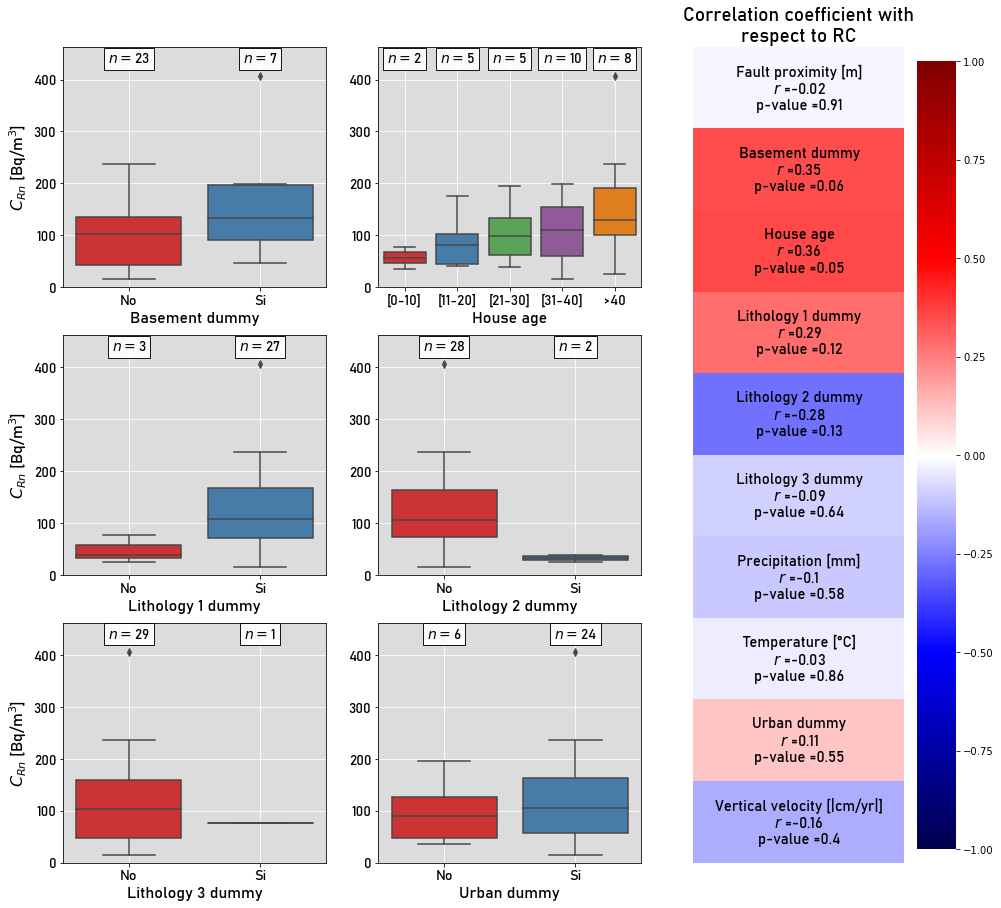

In [6]:
# r-pearson for variables with RC
r_Pvals = []
for i in range(len(DF_JOIN.columns)-1):
    r_Pvals.append(stats.pearsonr(np.array(DF_JOIN.Resultado), np.array(DF_JOIN.iloc[:,i+1])))
    
r_Pvals

fig = plt.figure(figsize = (16,15))
k = 0

for i in [2, 3, 4, 5, 6, 9]:
    
    if k<2:
        plt.subplot2grid((3,3), (0,k))
    elif k < 4:
        plt.subplot2grid((3,3), (1,k-2))
    else:
        plt.subplot2grid((3,3), (2,k-4))
    k+=1
    
    plt.ylim((0,462))
    ax=plt.gca()
    ax.set_facecolor('gainsboro')
    ax.set_axisbelow(True)
    
    ax2 = sns.boxplot(y = DF_JOIN.Resultado, x = DF_JOIN.iloc[:,i], palette = sns.color_palette("Set1"), zorder = 2)
    
    for j in range(len(DF_JOIN.iloc[:,i].unique())):
        if i == 3:
            plt.text(j,440,'$n = $'+str(sum(DF_JOIN.iloc[:,i] == j+1)), ha = 'center', va = 'center', bbox = dict(facecolor='w', alpha=0.9), fontdict = dict(family = 'bahnschrift', fontsize = 14))
            ax2.set_xticklabels(['[0-10]', '[11-20]', '[21-30]', '[31-40]', '>40'], family = 'bahnschrift', fontsize=14)
        else:
            plt.text(j,440,'$n = $'+str(sum(DF_JOIN.iloc[:,i] == j)), ha = 'center', va = 'center', bbox = dict(facecolor='w', alpha=0.9), fontdict = dict(family = 'bahnschrift', fontsize = 14))
            ax2.set_xticklabels(['No', 'Si'], family = 'bahnschrift', fontsize=14)
    ax2.set_yticklabels([0,100,200,300,400], family = 'bahnschrift',fontsize=14)
    if (k != 1) and (k!=3) and (k!=5):
        ax2.set_ylabel('')
    else:
        ax2.set_ylabel('$C_{Rn}$ [Bq/m$^3$]', fontsize=16, family = 'bahnschrift')
    ax2.set_xlabel(Variables[i-1], fontsize=16, family = 'bahnschrift')
    ax2.grid(color = 'w', zorder = -3)
    
ax7 = plt.subplot2grid((3, 3), (0, 2), rowspan=3)

Val = []
for i in range(len(Variables)):
    Val.append(Variables[i] + '\n$r$ =' +str(round(r_Pvals[i][0], 2)) + '\np-value =' +str(round(r_Pvals[i][1], 2)))

ax = sns.heatmap(pd.DataFrame(DF_JOIN.corr()['Resultado'].iloc[1:]), center = 0, vmin = -1, vmax = 1, cmap = 'seismic')
ax.set_yticklabels(Val, rotation = 0, x = 0.52, ha = 'center', family='bahnschrift', fontsize = 15)
ax.tick_params(length = 0)
ax.set_xticklabels([''], rotation = 0)
ax.set_title('Correlation coefficient with\nrespect to RC', family='bahnschrift', fontsize = 19)

fig.savefig('Figures/Caracterization.png', dpi = 250, bbox_inches = 'tight')

## Principal component Analysis

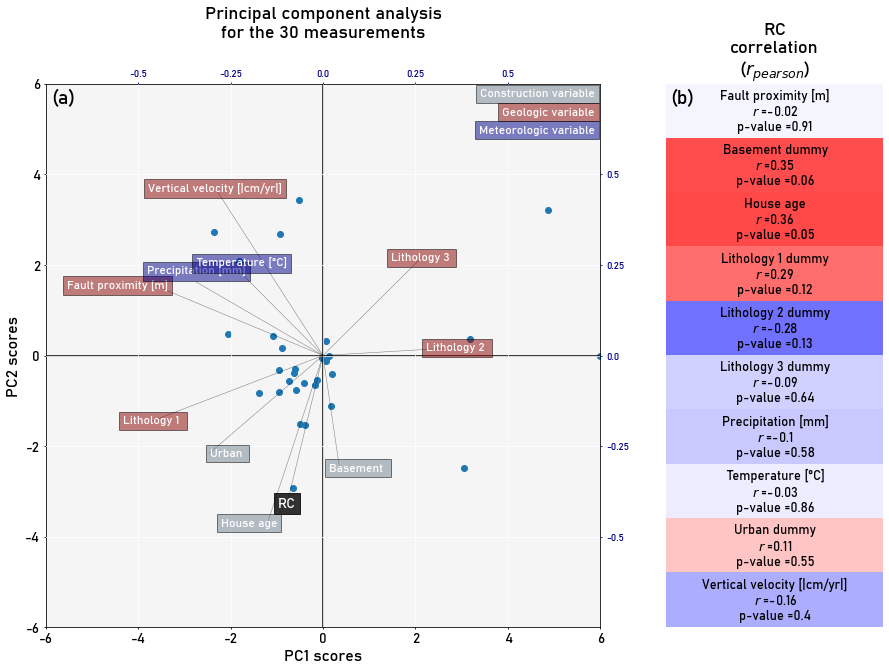

In [19]:
df_PCA = DF_JOIN

# Standarization
df_PCA = df_PCA.apply(lambda df : (df - np.mean(df))/np.std(df) )

Variables.insert(0,'RC')
df_PCA.columns = Variables

df_ = pd.DataFrame(df_PCA.corr().iloc[0,1:])

n_PCA = 5
pca = PCA(n_PCA)
A_postPCA = pca.fit_transform(df_PCA)
A_postPCA = pd.DataFrame(A_postPCA)

# Name the columns
cols = []
for i in range(len(A_postPCA.T)):
    cols.append('PC'+str(i+1))

A_postPCA.columns = cols

EigenVectors = pd.DataFrame(pca.components_.T)

fig = plt.figure(figsize = (15,10))

gs = gspec(10,15)

ax1=fig.add_subplot(gs[:,:10], label="1")
ax2=fig.add_subplot(gs[:,:10], label="2", frame_on=False)

ax1.scatter(A_postPCA.PC1, A_postPCA.PC2)

ax1.set_xlabel("PC1 scores", color="k", fontfamily = 'bahnschrift', fontsize = 16)
ax1.set_ylabel("PC2 scores", color="k", fontfamily  = 'bahnschrift', fontsize = 16)
ax1.tick_params(axis='x', colors="k", length = 2)
ax1.tick_params(axis='y', colors="k", length = 2)
ax2.set_xticks(np.arange(-6,7,2))
ax2.set_yticks(np.arange(-6,7,2))
ax1.set_yticklabels(np.arange(-6,7,2), family = 'bahnschrift', size = 14)
ax1.set_xticklabels(np.arange(-6,7,2), family = 'bahnschrift', size = 14)

plt.grid(True, color = 'w')

ax1.axhline(0,c='k')
ax1.axvline(0,c='k')

ax1.set_xlim(-6,6)
ax1.set_ylim(-6,6)


for i in range(len(EigenVectors)):
    ax2.plot([0,EigenVectors.iloc[i,0]],[0, EigenVectors.iloc[i,1]], c = 'k', lw = 0.5, alpha=0.5)
    if (i == 2)|(i == 9):
        plt.text(EigenVectors.iloc[i,0]+0.05, EigenVectors.iloc[i,1], df_PCA.iloc[:,i].name.split('dummy')[0], bbox = dict(facecolor='slategrey', alpha = 0.5), fontsize = 12, fontfamily = 'bahnschrift', ha = 'center',va = 'center', color='w')
    elif (i == 3):
        plt.text(EigenVectors.iloc[i,0]-0.05, EigenVectors.iloc[i,1], df_PCA.iloc[:,i].name.split('dummy')[0], bbox = dict(facecolor='slategrey', alpha = 0.5), fontsize = 12, fontfamily = 'bahnschrift', ha = 'center',va = 'center', color='w')
    elif (i == 4)|(i == 5)|(i == 6)|(i == 10):
        plt.text(EigenVectors.iloc[i,0], EigenVectors.iloc[i,1], df_PCA.iloc[:,i].name.split('dummy')[0], bbox = dict(facecolor='darkred', alpha = 0.5), fontsize = 12, fontfamily = 'bahnschrift', ha = 'center',va = 'center', color='w')
    elif (i == 1):
        plt.text(EigenVectors.iloc[i,0]-.1, EigenVectors.iloc[i,1], df_PCA.iloc[:,i].name.split('dummy')[0], bbox = dict(facecolor='darkred', alpha = 0.5), fontsize = 12, fontfamily = 'bahnschrift', ha = 'center',va = 'center', color='w')
    elif (i == 7)|(i == 8):
        plt.text(EigenVectors.iloc[i,0], EigenVectors.iloc[i,1]+0.03, df_PCA.iloc[:,i].name.split('dummy')[0], bbox = dict(facecolor='darkblue', alpha = 0.5), fontsize = 12, fontfamily = 'bahnschrift', ha = 'center',va = 'center', color='w')
    else:
        plt.text(EigenVectors.iloc[i,0], EigenVectors.iloc[i,1], df_PCA.iloc[:,i].name.split('dummy')[0], bbox = dict(facecolor='k', alpha = 0.8), fontsize = 14, fontfamily = 'bahnschrift', ha = 'center',va = 'center', color='w')
        

    
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.set_xticks(np.arange(-0.5,.7,.25))
ax2.set_yticks(np.arange(-0.5,.7,.25))
ax2.set_yticklabels(np.arange(-0.5,.7,.25), family = 'bahnschrift', size = 10)
ax2.set_xticklabels(np.arange(-0.5,.7,.25), family = 'bahnschrift', size = 10)
ax2.tick_params(axis='x', colors="darkblue",length = 2)
ax2.tick_params(axis='y', colors="darkblue",length = 2)

ax2.set_xlim(-.75,.75)
ax2.set_ylim(-.75,.75)

plt.text(-0.735,.736,'(a)', ha = 'left', va='top', fontsize = 20, fontfamily = 'bahnschrift')

plt.text(0.735,.736,'Construction variable', ha = 'right', va='top', fontsize = 12, color = 'w', bbox = dict(facecolor='slategray', alpha = 0.5), fontfamily = 'bahnschrift')
plt.text(0.735,.686,'Geologic variable', ha = 'right', va='top', fontsize = 12, color = 'w', bbox = dict(facecolor='darkred', alpha = 0.5), fontfamily = 'bahnschrift')
plt.text(0.735,.636,'Meteorologic variable', ha = 'right', va='top', fontsize = 12, color = 'w', bbox = dict(facecolor='darkblue', alpha = 0.5), fontfamily = 'bahnschrift')


plt.title('Principal component analysis\nfor the 30 measurements', y = 1.075, fontsize = 18, fontfamily = 'bahnschrift')

ax1.set_facecolor('whitesmoke')

ax3 = fig.add_subplot(gs[:,11:], label='3')

df_ = df_PCA.corr(method = 'pearson').apply(lambda df : df[np.abs(df) >= 0.0])
df_ = df_.loc[df_.columns]
df_ = pd.DataFrame(df_.iloc[1:,0])
sns.heatmap(df_, cmap='seismic', vmin = -1,vmax = 1, alpha = 1, cbar = False, zorder = -2)

ax3.tick_params(axis='x', length = 0)
ax3.tick_params(axis='y', length = 0)

Val = []
for i in range(len(df_PCA.columns)-1):
    Val.append(list(df_PCA.columns)[i+1] + '\n$r$ =' +str(round(r_Pvals[i][0], 2)) + '\np-value =' +str(round(r_Pvals[i][1], 2)))
    
ax3.set_yticklabels(Val, rotation = 0, x = 0.52 , ha = 'center', family='bahnschrift', fontsize = 13, color = 'k', zorder = 5)

ax3.set_xticklabels([''], rotation = 0)

plt.text(0.02,0.1,'(b)', ha = 'left', va='top', fontsize = 20, fontfamily = 'bahnschrift')

plt.title('RC\ncorrelation\n($r_{pearson}$)',  y = 1.075, fontsize = 18, fontfamily = 'bahnschrift')

fig.savefig('Figures/PCA_RC.png', dpi  = 170, bbox_inches = 'tight')

Variables.remove('RC')

## Statistical regression models

In [8]:
X = DF_JOIN.iloc[:,1:]
y = DF_JOIN.iloc[:,0]
y_log = y.apply(lambda df: 1 if df >= 100 else 0)
X_log = X
X_log['Constante'] = np.ones(30)
X['Constante'] = np.ones(30)

### Linear regression

In [9]:
lin_reg = sm.OLS(y, X).fit(maxiter=1000000)

RMSE = np.sqrt(np.sum((lin_reg.predict(X)-y)**2)/30)

print('RMSE:', RMSE)

lin_reg.summary(alpha = 0.1)
lin_reg.pvalues

RMSE: 64.06206146691201


DistanciaFalla         0.926819
sotano_dummy           0.129127
edad_casa              0.086721
Lito_SGC_Arcillas,_    0.579873
Lito_SGC_Abanicos_a    0.732221
Lito_SGC_Shales,_ca    0.545338
Precipitacion_mes      0.642277
Temperatura            0.624658
Urbano_dummy           0.995740
Vertical_velocity      0.762017
Constante              0.608722
dtype: float64

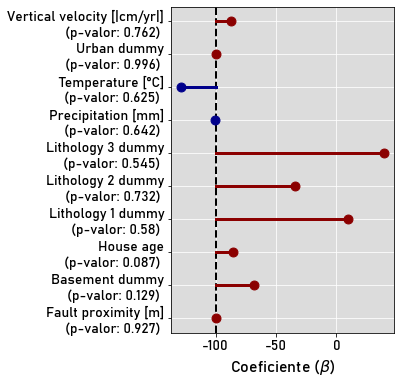

In [10]:
fig = plt.figure(figsize = (4,6))

plt.grid(True, which = 'both',  zorder = -3, c = 'w')

for i in range(len(lin_reg.params.iloc[:-1])):
    
    if lin_reg.params.iloc[i] > 0:
        plt.scatter((lin_reg.params.iloc[i]), Variables[i], s = 80, c = 'darkred', zorder = 4)
        plt.plot([1,(lin_reg.params.iloc[i])], [Variables[i], Variables[i]], c = 'darkred', linewidth = 3, zorder = 4)
    else:
        plt.scatter((lin_reg.params.iloc[i]), Variables[i], s = 80, c = 'darkblue', zorder = 4)
        plt.plot([1,(lin_reg.params.iloc[i])], [Variables[i], Variables[i]], c = 'darkblue', linewidth = 3, zorder = 4)

Val = []
for i in range(len(Variables)):
    Val.append(Variables[i] + '\n(p-valor: '+str(round(lin_reg.pvalues.iloc[i],3))+') ')
        
ax = plt.gca()

ax.set_xlabel('Coeficiente ($\u03B2$)', family = 'bahnschrift', fontsize = 16)
ax.set_yticklabels(Val, family = 'bahnschrift', fontsize = 14)
ax.set_xticklabels(np.arange(-150,150,50), family = 'bahnschrift', fontsize = 14)
ax.set_facecolor('gainsboro')

plt.axvline(0, c = 'k',ls='--', lw=2)

fig.savefig('Figures/Regresión_Lineal.png', dpi = 200, bbox_inches = 'tight')

### Logistic regression

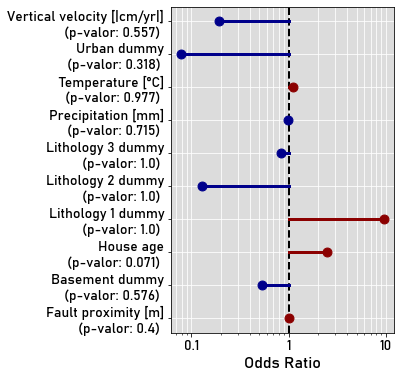

In [11]:
lgReg = LogisticRegression(max_iter = 50000, fit_intercept=False, solver = 'lbfgs',penalty = 'l2', C = 10)

lgReg.fit(X_log,y_log)

errores = (lgReg.predict(X_log)-y_log)

OR = np.exp(lgReg.coef_)

denom = (2.0*(1.0+np.cosh(lgReg.decision_function(X_log))))
denom = np.tile(denom,(X_log.shape[1],1)).T
F_ij = np.dot((X_log/denom).T,X_log) ## Fisher Information Matrix
Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
sigma_estimates = np.sqrt(np.abs(np.diagonal(Cramer_Rao)))
z_scores = lgReg.coef_[0]/sigma_estimates # z-score for eaach model coefficient
p_values = [stats.norm.sf(abs(x))*2 for x in z_scores] ### two tailed test for p-values

DF_log = pd.DataFrame([lgReg.coef_[0], np.exp(lgReg.coef_[0]), p_values]).T
DF_log.columns = ['Beta', 'OR', 'p-values']

fig = plt.figure(figsize = (4,6))

plt.grid(True, which = 'both',  zorder = -3, c = 'w')

for i in range(len(lgReg.coef_[0][:-1])):
    if lgReg.coef_[0][:-1][i] > 0:
        plt.scatter(np.exp(lgReg.coef_[0][:-1][i]), Variables[i], s = 80, c = 'darkred', zorder = 4)
        plt.plot([1,np.exp(lgReg.coef_[0][:-1][i])], [Variables[i], Variables[i]], c = 'darkred', linewidth = 3, zorder = 4)
    else:
        plt.scatter(np.exp(lgReg.coef_[0][:-1][i]), Variables[i], s = 80, c = 'darkblue', zorder = 4)
        plt.plot([1,np.exp(lgReg.coef_[0][:-1][i])], [Variables[i], Variables[i]], c = 'darkblue', linewidth = 3, zorder = 4)


Val = []
for i in range(len(Variables)):
    Val.append(Variables[i] + '\n(p-valor: '+str(round(p_values[i],3))+') ')

ax = plt.gca()

plt.xscale('log')
ax.set_xlabel('Odds Ratio', family = 'bahnschrift', fontsize = 16)
ax.set_xticks([0.1,1,10])
ax.set_yticklabels(Val, family = 'bahnschrift', fontsize = 14)
ax.set_xticklabels(['0.1','1','10'], family = 'bahnschrift', fontsize = 14)
ax.set_facecolor('gainsboro')


plt.axvline(1, c = 'k',ls='--', lw=2)

fig.savefig('Figures/Regresión_Logística.png', dpi = 200, bbox_inches = 'tight')

## Apply models to Household data

In [12]:
df_RnModel = pd.read_table("Independent variables/Houses_IndVar_model.txt", delimiter = ',')

df_RnModel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 725932 entries, 0 to 725931
Data columns (total 35 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   OID_            725932 non-null  int64  
 1   Join_Count      725932 non-null  int64  
 2   TARGET_FID      725932 non-null  int64  
 3   Join_Count_1    725932 non-null  int64  
 4   TARGET_FID_1    725932 non-null  int64  
 5   COD_1           725932 non-null  object 
 6   MEAN_CONNPISOS  725932 non-null  float64
 7   MAX_CONNSOTANO  725932 non-null  int64  
 8   MEAN_BASEMENT   725932 non-null  float64
 9   MEAN_AGE_RANK   725932 non-null  float64
 10  ORIG_FID        725932 non-null  int64  
 11  SimboloUC       725932 non-null  object 
 12  Descripcion     725932 non-null  object 
 13  SueCodigo       725802 non-null  float64
 14  SueCSuelo       725802 non-null  float64
 15  SueAAdmini      725802 non-null  object 
 16  SueArea         725802 non-null  float64
 17  Shape_Leng

In [13]:
df_RnModel = df_RnModel.dropna()

df_RnModel['Urban_dummy'] = df_RnModel['SueCodigo'].apply(lambda df : 1 if df == 1 else 0)

# Create dummy variables
for i in df_RnModel['SimboloUC'].unique():
    df_RnModel['Lito_SGC_'+i.replace('-','_')[:10]] = df_RnModel.apply(lambda df : 1 if df['SimboloUC'] == i else 0, axis = 1)
    
df_RnModel['Constant'] = np.ones(len(df_RnModel))

df_RnModel = df_RnModel[(df_RnModel['SimboloUC'] == 'Q1-l')|
                        (df_RnModel['SimboloUC'] == 'Q-ca')|
                        (df_RnModel['SimboloUC'] == 'k1k6-Stm')]

df_RnModel = df_RnModel[['COD_1',
                         'NEAR_DIST', 
                         'MEAN_BASEMENT',
                         'MEAN_AGE_RANK',
                         'Lito_SGC_Q1_l',
                         'Lito_SGC_Q_ca',
                         'Lito_SGC_k1k6_Stm', 
                         'MEAN_12', 
                         'MEAN_1', 
                         'Urban_dummy', 
                         'MEAN', 
                         'Constant']]

In [14]:
df_RnModel.columns = ['COD',
                      'Fault_proximity',
                      'Basement_dummy',
                      'Age_rank',
                      'Lito_SGC_Q1_l', 
                      'Lito_SGC_Q_ca', 
                      'Lito_SGC_k1k6_Stm', 
                      'Precipitation', 
                      'Temperature', 
                      'Urban_dummy', 
                      'Vertical_velocity', 
                      'Constant']

### Linear regession

In [15]:
df_RnModel['LinReg'] = lin_reg.predict(df_RnModel.iloc[:,1:])

### Logistic regression

In [16]:
df_RnModel['LogReg'] = lgReg.predict_proba(df_RnModel.iloc[:,1:-1])[:,1]

C:\Users\mdomi\anaconda3\lib\site-packages\sklearn\base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Age_rank
- Basement_dummy
- Constant
- Fault_proximity
- Lito_SGC_Q1_l
- ...
Feature names seen at fit time, yet now missing:
- Constante
- DistanciaFalla
- Lito_SGC_Abanicos_a
- Lito_SGC_Arcillas,_
- Lito_SGC_Shales,_ca
- ...

  warnings.warn(message, FutureWarning)


In [17]:
df_RnModel.to_csv('Stat_models_results.csv')